# Question Clustering in Python

In [2]:
from download import download_squad, collect_squad_data, download_fasttext, download_infersent, build_infersent_model
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mille\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# download_squad()
# download_fasttext()
# download_infersent()

In [4]:
squadJson = collect_squad_data()

In [5]:
for subject in squadJson['data'][:2]:
    print("\nTitle: {0}\n".format(subject['title']))
    for paragraph in subject['paragraphs'][:2]:
        print("\tContext: {0}\n".format(paragraph['context']))
        for qa in paragraph['qas'][:2]:
            print("\tQuestion: {0}\n".format(qa['question']))
            print("\tAnswer: {0}\n".format(qa['answers']))


Title: University_of_Notre_Dame

	Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

	Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

	Answer: [{'answer_start': 515, 'text': 'Saint Bernadette Soubirous'}]

	Question: What is in front of the Notre Dame Main Building?

	Answer: [{'answer_start': 188, 'text': '

## Question Corpus

In [6]:
questions = [{'question':qa['question'],'paragraph':p,'subject':subject['title']}
                 for subject in squadJson['data']
                 for p,paragraph in enumerate(subject['paragraphs'])
                 for qa in paragraph['qas']] 

In [7]:
len(questions)

87599

In [8]:
questions[:10]

[{'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
  'paragraph': 0,
  'subject': 'University_of_Notre_Dame'},
 {'question': 'What is in front of the Notre Dame Main Building?',
  'paragraph': 0,
  'subject': 'University_of_Notre_Dame'},
 {'question': 'The Basilica of the Sacred heart at Notre Dame is beside to which structure?',
  'paragraph': 0,
  'subject': 'University_of_Notre_Dame'},
 {'question': 'What is the Grotto at Notre Dame?',
  'paragraph': 0,
  'subject': 'University_of_Notre_Dame'},
 {'question': 'What sits on top of the Main Building at Notre Dame?',
  'paragraph': 0,
  'subject': 'University_of_Notre_Dame'},
 {'question': 'When did the Scholastic Magazine of Notre dame begin publishing?',
  'paragraph': 1,
  'subject': 'University_of_Notre_Dame'},
 {'question': "How often is Notre Dame's the Juggler published?",
  'paragraph': 1,
  'subject': 'University_of_Notre_Dame'},
 {'question': 'What is the daily student paper at Notre Dame 

## Question Encoding

In [9]:
model=build_infersent_model()

Vocab size : 100000.0


In [10]:
embeddings = model.encode([q['question'] for q in questions], 
                          bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 933196/1056541 (88.3%)


C:\Users\Mille\Documents\GitHub\millerdw.github.io\_notebooks\FindingTheWords_5\models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


Speed : 1648.4 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 87599


In [11]:
embeddings.shape

(87599, 4096)

In [12]:
for i in range(len(questions)):
    questions[i]['encoding']=embeddings[i]

In [13]:
titles = list(set([q['subject'] for q in questions]))

### k-Means

In [14]:
import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
# from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.preprocessing import RobustScaler
# from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans, DBSCAN, Birch, OPTICS
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

In [15]:
import numpy as np

### High Level Topic Clustering

In [16]:
subdataset=[q for q in questions if q['subject'] in titles[:10]]

In [17]:
X_train = np.stack([q['encoding'] for q in subdataset])

In [18]:
len(X_train)

2033

In [19]:
kmeans = KMeans(n_clusters=80, random_state=0).fit(X_train)

In [20]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, kmeans.labels_))

Silhouette Coefficient: 0.034


In [21]:
for i in range(len(subdataset)):
    subdataset[i]['label']=kmeans.labels_[i]

In [22]:
labels=list(set(kmeans.labels_))

In [23]:
for label in labels[:10]:
    print("Cluster {0}:".format(label))
    qs=[q for q in subdataset if q['label']==label][:10]
    for q in qs:
        print("\t{0}".format(q['question']))
    

Cluster 0:
	Which year was used for estimates in the 2011 report?
	Which year was used for estimates in the 2015 report?
	Which year was used for estimates in the 2014 report?
	What is the main reason that countries were excluded from the 2014 report?
	Which East Asian dictatorship was excluded from the 2014 report?
	Which year was used for estimates in the 2013 report?
	Which year was used for estimates in the 2011 report?
	What is the main reason that countries were excluded from the 2011 report?
	Which East Asian dictatorship was excluded from the 2011 report?
	Which year was used for estimates in the 2010 report?
Cluster 1:
	Godel couldn't have come to his conclusion without what book?
	What obscures the importance of relations according to Whitehead?
	What makes up the sum of relations to an entity?
	How long did it actually take to complete Principia Mathematica? 
	How many modes does perception occur in according to Whitehead?
	What does the term "prehension" signify regarding a

### Low Level

In [24]:
subdataset=[q for q in questions if q['subject']==titles[1]]
X_train = np.stack([q['encoding'] for q in subdataset])
len(X_train)

317

In [25]:
kmeans = KMeans(n_clusters=80, random_state=0).fit(X_train)

In [26]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, kmeans.labels_))

Silhouette Coefficient: 0.054


In [27]:
for i in range(len(subdataset)):
    subdataset[i]['label']=kmeans.labels_[i]

In [28]:
labels=list(set(kmeans.labels_))

In [29]:
for label in labels[:10]:
    print("Cluster {0}:".format(label))
    qs=[q for q in subdataset if q['label']==label][:10]
    for q in qs:
        print("\t{0}".format(q['question']))
    

Cluster 0:
	What did Whitehead believe regarding the variety of subjects in education?
	What did Whitehead feel was necessary regarding basic assumptions in metaphysics?
	What did Whitehead regard as essential to good science and good philosophy?
	What did Whitehead believe regarding factors that limit people's understanding of his concepts?
	What did Whitehead publish numerous articles about?
	What lectures did Whitehead present in 1927-28?
Cluster 1:
	What was Whitehead's opinion of metaphysical investigations?
	What do philosophers do, in Whitehead's view?
	What was Whitehead's opinion on privacy?
	What was G.B. Matthew's opinion of "A Treatise on Algebra"?
	What was Charles Birch's profession besides theologian?
Cluster 2:
	What is the term for the experience dominating primitive organisms that have a sense for fate?
Cluster 3:
	In Whitehead's view, identities do not define people, but what?
	Most entities do not have what?
Cluster 4:
	Why was Gödels finding ironic?
	What important

## Hierarchical Clustering

In [30]:
from sklearn.cluster import AgglomerativeClustering

In [31]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram


In [32]:
subdataset=[q for q in questions if q['subject'] in titles[:10]]
X_train = np.stack([q['encoding'] for q in subdataset])

In [33]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X_train)

In [34]:
def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, 
                                      model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [35]:
len(model.labels_)

# A node i greater than or equal to n_samples is a non-leaf node and has children children_[i - n_samples]

# Or,  at the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i

# def get_children(root_id):
#     if root_id>=n_samples: # non-leaf node
        
#     else: #leaf node
#     children_ids=

tree_dict={i:(None if i<len(model.children_) else (model.children_[i-len(model.children_),0],
                                                   model.children_[i-len(model.children_),1])) 
           for i in range(2*len(model.children_))}

# tree_dict={i+len(model.children_):(None if i<len(model.children_) else (model.children_[i-len(model.children_),0],
#                                                    model.children_[i-len(model.children_),1])) 
#            for i in range(len(model.children_))}

rootindex=model.children_.max()
print(rootindex)
tree_dict[rootindex]




4063


(4062, 4063)

In [36]:
from IPython.core.debugger import set_trace

In [2]:
def get_children(tree, depth, parent=None, current_depth=0):
    if parent is None:
        parent = max(tree.keys())

    if tree[parent] is None:
        return [parent]
    else:
        children_a=get_children(tree,depth,parent=tree[parent][0],current_depth=current_depth+1)
        children_b=get_children(tree,depth,parent=tree[parent][1],current_depth=current_depth+1)
        if current_depth==depth:
            set_trace
            return [(tree[parent][0],children_a)]+[(tree[parent][1],children_b)]
        else:
            
            return children_a+children_b

In [3]:
children = get_children(tree_dict, depth=5)

NameError: name 'tree_dict' is not defined

In [69]:
max(tree_dict.keys())

3745

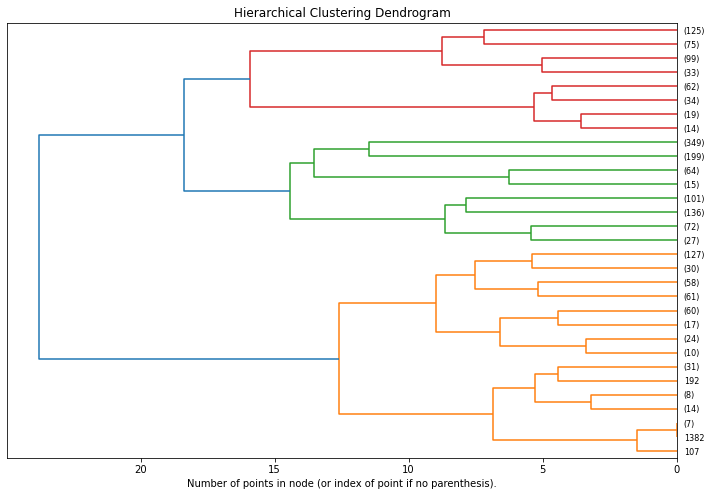

In [66]:
level=4
plt.figure(figsize=(12,max(2*level,4)))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, 
                truncate_mode='level', 
#                 labels=model.labels_,
                p=level,
                orientation='left')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()